In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from keras.models import Sequential,Model
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.layers import Conv2D,Dropout,MaxPooling2D,Flatten,Dense,BatchNormalization
import keras
import os

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [3]:
s=227

In [4]:
training_set = train_datagen.flow_from_directory(
    '/kaggle/input/chest-ctscan-images/Data/train', 
    color_mode="rgb",
    target_size=(s,s),
    batch_size=12,
    class_mode='categorical'
)

Found 613 images belonging to 4 classes.


In [5]:
val_set = val_datagen.flow_from_directory(
    '/kaggle/input/chest-ctscan-images/Data/test', 
    color_mode="rgb",
    target_size=(s,s),
    batch_size=4,
    class_mode='categorical'
)

Found 315 images belonging to 4 classes.


In [6]:
test_set = test_datagen.flow_from_directory(
    '/kaggle/input/chest-ctscan-images/Data/test', 
    color_mode="rgb",
    target_size=(s,s),
    batch_size=4,
    class_mode='categorical'
)

Found 315 images belonging to 4 classes.


In [7]:
model = Xception(weights='imagenet',include_top=False,input_shape=(s,s,3))
for layer in model.layers:
    layer.trainable = False
x = model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(4, activation='softmax')(x)
model = Model(model.input, out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 113, 113, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 113, 113, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    mode='max'
)
res = model.fit(training_set,
          epochs = 32,
          callbacks=[custom_early_stopping],
          validation_data = test_set)

Epoch 1/32
52/52 [==============================] - 27s 340ms/step - loss: 1.6063 - accuracy: 0.4731 - val_loss: 8.7237 - val_accuracy: 0.2032
Epoch 2/32
52/52 [==============================] - 12s 235ms/step - loss: 1.3812 - accuracy: 0.5383 - val_loss: 3.6926 - val_accuracy: 0.5333
Epoch 3/32
52/52 [==============================] - 12s 234ms/step - loss: 1.1452 - accuracy: 0.5824 - val_loss: 1.5434 - val_accuracy: 0.5492
Epoch 4/32
52/52 [==============================] - 13s 246ms/step - loss: 0.8702 - accuracy: 0.6656 - val_loss: 1.5467 - val_accuracy: 0.5651
Epoch 5/32
52/52 [==============================] - 12s 235ms/step - loss: 0.7912 - accuracy: 0.6982 - val_loss: 1.7430 - val_accuracy: 0.4952
Epoch 6/32
52/52 [==============================] - 13s 242ms/step - loss: 0.7343 - accuracy: 0.7390 - val_loss: 1.0818 - val_accuracy: 0.5968
Epoch 7/32
52/52 [==============================] - 12s 231ms/step - loss: 0.5920 - accuracy: 0.7945 - val_loss: 0.8352 - val_accuracy: 0.6730

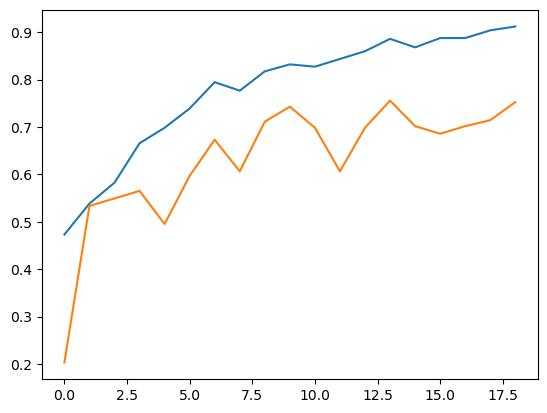

In [9]:
plt.plot(res.history['accuracy'])
plt.plot(res.history['val_accuracy'])

In [10]:
model.evaluate(test_set)

79/79 [==============================] - 2s 29ms/step - loss: 0.7377 - accuracy: 0.7524


[0.7376854419708252, 0.7523809671401978]

In [11]:
predict=model.predict(test_set)
predict=np.argmax(predict,axis = 1)
from sklearn.metrics import accuracy_score
Acc = accuracy_score(test_set.classes,predict)
print("Accuracy = ", Acc)

79/79 [==============================] - 3s 29ms/step
Accuracy =  0.273015873015873
